Setup

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import os
from tqdm.notebook import tqdm
from datetime import datetime
import pathlib

sys.path.append(f'../libs')
sys.path.append(f'../libs/openlap')
 # cd "C:\Program Files\MATLAB\R2022a\extern\engines\python" 

import matlab.engine

In [5]:
OLAP_DIR = '../libs/openlap'
CAR_FILE = 'car.xlsx'
SIMS_FOLDER = 'OpenLAP Sims'
TEST_SETUP_FINAL = 'OpenLAP_Formula 1_Autodromo Nazionale Monza.csv'

Basic Cals

In [6]:
# Calculates the Coefficient of Drag
def calculate_cd(*, cdf: float = None, cl: float = None, clo: float = 0.01, 
                 cdo: float = 0.6, k: float = 0.04) -> float:
    """Calculates the Coefficient of Drag off a Given Coefficient of Downforce
    Note: Default values are for the paper's car vals, MUST CHANGE FOR ANY OTHER SETUP

    Args:
        cdf (float): Coefficient of Downforce
        clo (float, optional): Coefficient of Lift (no-aero). Paper-Defaults to 0.01.
        cdo (float, optional): Coefficient of Drag (no-aero). Paper-Defaults to 0.6.
        k (float, optional): Polar Coefficient? (is power to mass ratio?). Paper-Defaults to 0.04.

    Returns:
        float: Calculated Coefficient of Drag
    """
    
    if cl is None:
        cl = -cdf  # Coefficient of Lift
        
    cd = -(k*(cl-clo)**2 + cdo)  # Coefficient of Drag
    return cd


def get_cl_cd_pairs(cl_range: float = None, cd_range: float = None,
                    n: int = 10, **kwargs) -> tuple:
    """Get cl and cd pairs

    Args:
        cl_range (float, optional): Range given by cl. Defaults to None.
        cd_range (float, optional): Range given by cd. Defaults to None.
        n (int, optional): _description_. Defaults to 10.

    Returns:
        tuple: (cl, cd)

    Yields:
        Iterator[float]: (cl, cd) tuple
    """
    
    if cl_range is None and cd_range is not None:
        iter_range = cd_range
        
    elif cl_range is not None and cd_range is None:
        iter_range = cl_range
    
    else:
        raise ValueError('Need to pass either cl_range or cd_range, and not both')
            
    for cl in np.linspace(*iter_range, n):
        yield (cl, calculate_cd(cl = cl, **kwargs))


# x = -np.linspace(0, 8, 80)
# plt.plot(x, calculate_cd(cl=x))
# plt.show()

Doing the Stuff through OpenLAP

In [7]:
# # The csv data is seperated weirdly  (note for header, it ignores blank lines)
# df = pd.read_csv(f'{OLAP_DIR}/{SIMS_FOLDER}/{TEST_SETUP_FINAL}', header=[10, 11])

In [8]:
def edit_cl_cd(cl: float, cd: float, file: str = 'car.xlsx'):
    vehicle_details = pd.read_excel(f'{OLAP_DIR}/{file}', sheet_name='Info')
    vehicle_torque = pd.read_excel(f'{OLAP_DIR}/{file}', sheet_name='Torque Curve')

    vehicle_details.loc[vehicle_details['Description'] == 'Drag Coefficient CD', 'Value'] = cd
    vehicle_details.loc[vehicle_details['Description'] == 'Lift Coefficient CL', 'Value'] = cl
    # print(vehicle_details.head(14))

    writer = pd.ExcelWriter(f'{OLAP_DIR}/{file}', engine='xlsxwriter')
    vehicle_details.to_excel(writer, sheet_name='Info', index=False)
    vehicle_torque.to_excel(writer, sheet_name='Torque Curve', index=False)
    writer.save()

In [9]:
## SETUP
def simulate(cl_range: list[float], eng: matlab.engine.EngineSession, n=5) -> pd.DataFrame:
    # try running the sim from python


    # other things
    current_time = datetime.now().strftime("%d %h %y %H-%M")
    try:
        os.mkdir(f'../results/{current_time}')
    except FileExistsError:
        pass
    results = pd.DataFrame(float(0), index=list(range(0,n)), columns=['time', 'cl'])  # (time, cl)

    # Main ittr
    for run, cl_cd_tuple in tqdm(enumerate(get_cl_cd_pairs(cl_range=cl_range, n=n)), total=n, desc='setup iteration'):
        # NOTE:
        # # look at multiprocessing, and speed up tools in python, forgot name
        
        # tqdm sub loop
        # with tqdm(total=5, desc='sub tasks') as pbar:
        # Unpack tuple
        print(f'{run=}, {cl_cd_tuple=}')
        cl, cd = cl_cd_tuple
        
        # First, edit the vehicle file
        edit_cl_cd(cl = cl, cd = cd)
        # pbar.update()
        
        # Build the vehicle model
        eng.run('OpenVEHICLE.m', nargout=0)
        eng.close()  # Clears figures
        # pbar.update()
        
        # Simulate the Lap
        eng.run('OpenLAP.m', nargout=0)  # Runs lap sim
        eng.close() 
        # pbar.update()
        
        # Rename the files
        curr_dir = f'../results/{current_time}/{run=};cl={cl:.3f};cd={cd:.3f}'
        try:
            os.rename(f'{OLAP_DIR}/OpenLap Sims', curr_dir)
        except FileExistsError:
            pass
        # pbar.update()
        
        # Read in the goods
        csv_file = str(next(pathlib.Path(curr_dir).glob('*.csv')))
        df = pd.read_csv(f'{csv_file}', header=10).iloc[1:]
        results.loc[run, 'time'] = df.iloc[-1]['time']
        results.loc[run, 'cl'] = cl
        # pbar.update()
        
        # pbar.reset()
        
    return results

# simulate([-1, -8], None)


In [10]:
# init
cl_range = [-1, -8]

# Start matlab
eng = matlab.engine.start_matlab()
eng.cd(f'D:/Redback/Aero/libs/openlap')

# Simulate
for i in range(1):
    results = simulate(cl_range, eng) 
    min = results['time'].astype(float).idxmin()
    print(f'{min=}')
    cl_range[0] = results.loc[min-1, 'cl']
    cl_range[1] = results.loc[min+1, 'cl']

setup iteration:   0%|          | 0/5 [00:00<?, ?it/s]

run=0, cl_cd_tuple=(-1.0, -0.6408039999999999)


,time,cl
0,79.180000,-3.406250
1,79.139999,-3.460938
2,79.120003,-3.515625
3,79.099998,-3.570312
4,79.120003,-3.625000


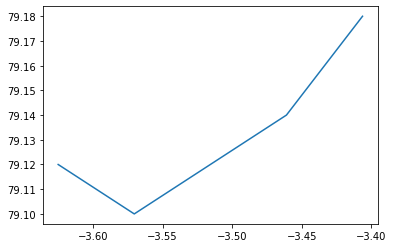

In [ ]:
plt.plot(results['cl'].astype(float), results['time'].astype(float))
results